In [1]:
import src.data
import src.lfads_helpers
import src.util
import pyaldata
import yaml
import matplotlib.pyplot as plt
import numpy as np
from src.models import SSA
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import KDTree

sns.set_context('talk')

%load_ext autoreload
%autoreload 2

In [2]:
with open('../params.yaml', 'r') as params_file:
    full_params = yaml.safe_load(params_file)
    lfads_params = full_params['lfads_prep']
    analysis_params = full_params['analysis']

trial_data = src.data.load_clean_data('../data/trial_data/Earl_20190716_COCST_TD.mat')
td_co = src.lfads_helpers.prep_data_with_lfads(trial_data, 'CO', lfads_params)
td_cst = src.lfads_helpers.prep_data_with_lfads(trial_data,'CST', lfads_params)

# rebin at larger bin size
td_co = pyaldata.combine_time_bins(td_co, n_bins=int(analysis_params['bin_size']/td_co['bin_size'].values[0]))
td_cst = pyaldata.combine_time_bins(td_cst, n_bins=int(analysis_params['bin_size']/td_cst['bin_size'].values[0]))

td_co = pyaldata.add_gradient(td_co,'lfads_pca',normalize=True)
td_cst = pyaldata.add_gradient(td_cst,'lfads_pca',normalize=True)

co_epoch_fun = src.util.generate_realtime_epoch_fun(
    'idx_goCueTime',
    rel_start_time=-1.0,
    rel_end_time=0.5,
)
cst_epoch_fun = src.util.generate_realtime_epoch_fun(
    'idx_goCueTime',
    rel_start_time=-1.0,
    rel_end_time=5.0,
)
td_co = pyaldata.restrict_to_interval(td_co,epoch_fun=co_epoch_fun)
td_cst = pyaldata.restrict_to_interval(td_cst,epoch_fun=cst_epoch_fun)

/home/raeed/miniconda3/envs/autolfads-tf2/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [  7   8  18  19  22  24  25  33  34  36  56  62  66  86  92  94  95 103
 110 112 115 120 123 131 137 139 146 157 159 161 162 165 173 181 187 200
 218 222 224 225 229 230 237 239 244 249 254 261 266 269 271 281 286 304
 306 308 309 316 321 334 338 342 344 347 351 352 355 357 360 361 366 369
 370 371 373 376 378 381 382 384 386 388 393 394 399 403 404 405 408 409
 411 413 416 420 422 423 424 426 427 428 429 431 435 436 437 446 447 452
 454 456 458 459 460 461 462 464 469 472 476 477 481 488 489 490 491 492
 494 500 508 509 510 512 513 516 519 534 535 536]
/home/raeed/miniconda3/envs/autolfads-tf2/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more inf

In [3]:
def calc_neural_tangling(x,dx,num_neighbors=None,const_norm=True,take_max=False):
    norm_adjust = 1e-6 if const_norm else 0.1*sum(x.var())
    
    if num_neighbors is None:
        full_tang = pdist(dx,metric='sqeuclidean')/(pdist(x,metric='sqeuclidean')+norm_adjust)
        q = squareform(full_tang).max(axis=1) if take_max else np.percentile(squareform(full_tang),99,axis=1)
    else:
        raise NotImplementedError

    return q


In [4]:
td_co = src.data.add_trial_time(td_co,ref_event='idx_goCueTime')
df_co = src.util.crystallize_dataframe(td_co,sigs=['trialtime','lfads_pca','dlfads_pca','lfads_inputs','rel_hand_pos','hand_vel'])
meta_co = src.util.extract_metaframe(td_co,metacols=['trial_id','tgtDir','tgtMag'])
df_co = df_co.join(meta_co,on='trial_id')
df_co['Tangling'] = calc_neural_tangling(df_co['lfads_pca'],df_co['dlfads_pca'])
df_co['LFADS input norm'] = np.linalg.norm(df_co['lfads_inputs'],axis=1)

In [5]:
from ipywidgets import interact
@interact(co_trial_id=list(df_co.groupby('trial_id').groups.keys()))
def plot_trials(co_trial_id):
    fig,axs = plt.subplots(3,1,figsize=(8,8),sharex=True)
    trial = df_co.groupby('trial_id').get_group(co_trial_id)
    sns.lineplot(
        ax=axs[0],
        data=trial,
        x=('trialtime',0),
        y='Tangling',
    )
    sns.lineplot(
        ax=axs[1],
        data=trial,
        x=('trialtime',0),
        y='LFADS input norm',
    )
    sns.lineplot(
        ax=axs[2],
        data=trial,
        x=('trialtime',0),
        y=('rel_hand_pos',0),
    )
    for ax in axs:
        # TODO: make the go cue dash depend on the chosen bin size
        ax.plot([0,0],ax.get_ylim(),'k--')
    sns.despine(fig=fig,trim=True)

interactive(children=(Dropdown(description='co_trial_id', options=(11, 16, 17, 23, 40, 45, 47, 58, 59, 65, 69,…

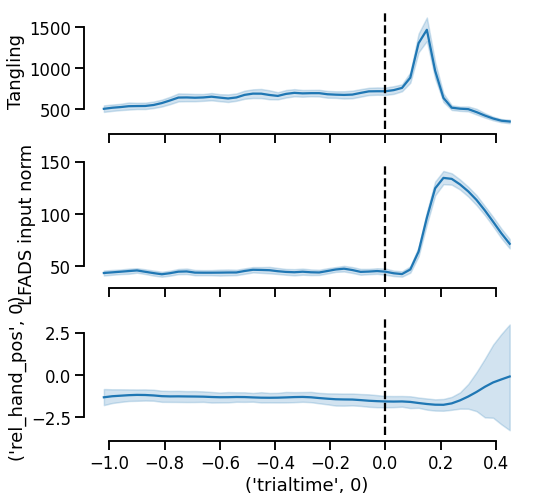

In [13]:
fig,axs = plt.subplots(3,1,figsize=(8,8),sharex=True)
sns.lineplot(
    ax=axs[0],
    data=df_co,
    x=('trialtime',0),
    y='Tangling',
)
sns.lineplot(
    ax=axs[1],
    data=df_co,
    x=('trialtime',0),
    y='LFADS input norm',
)
sns.lineplot(
    ax=axs[2],
    data=df_co,
    x=('trialtime',0),
    y=('rel_hand_pos',0),
)
for ax in axs:
    # TODO: make the go cue dash depend on the chosen bin size
    ax.plot([0,0],ax.get_ylim(),'k--')
sns.despine(fig=fig,trim=True)

In [6]:
td_cst = src.data.add_trial_time(td_cst,ref_event='idx_goCueTime')
df_cst = src.util.crystallize_dataframe(td_cst,sigs=['trialtime','lfads_pca','dlfads_pca','lfads_inputs','rel_hand_pos','hand_vel','rel_cursor_pos','cursor_vel'])
df_cst['LFADS input norm'] = np.linalg.norm(df_cst['lfads_inputs'],axis=1)

In [7]:
@interact(cst_trial_id=list(df_cst.groupby('trial_id').groups.keys()))
def plot_trials(cst_trial_id):
    fig,axs = plt.subplots(3,1,figsize=(8,8),sharex=True)
    trial = df_cst.groupby('trial_id').get_group(cst_trial_id)
    sns.lineplot(
        ax=axs[1],
        data=trial,
        x=('trialtime',0),
        y='LFADS input norm',
    )
    axs[1].set_ylim(0,100)
    sns.lineplot(
        ax=axs[2],
        data=trial,
        x=('trialtime',0),
        y=('rel_hand_pos',0),
        color='r',
    )
    sns.lineplot(
        ax=axs[2],
        data=trial,
        x=('trialtime',0),
        y=('rel_cursor_pos',0),
        color='b',
    )
    axs[2].set_ylabel('Hand/cursor position')
    for ax in axs:
        # TODO: make the go cue dash depend on the chosen bin size
        ax.plot([0,0],ax.get_ylim(),'k--')
    sns.despine(fig=fig,trim=True)

interactive(children=(Dropdown(description='cst_trial_id', options=(1, 2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 15, 2…

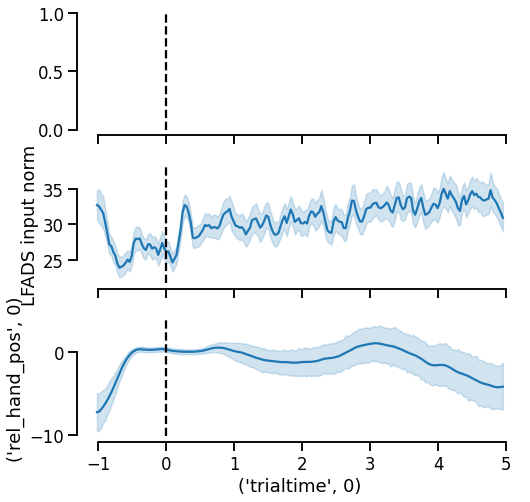

In [14]:
fig,axs = plt.subplots(3,1,figsize=(8,8),sharex=True)
# sns.lineplot(
#     ax=axs[0],
#     data=df_cst,
#     x=('trialtime',0),
#     y='Tangling',
# )
sns.lineplot(
    ax=axs[1],
    data=df_cst,
    x=('trialtime',0),
    y='LFADS input norm',
)
sns.lineplot(
    ax=axs[2],
    data=df_cst,
    x=('trialtime',0),
    y=('rel_hand_pos',0),
)
for ax in axs:
    # TODO: make the go cue dash depend on the chosen bin size
    ax.plot([0,0],ax.get_ylim(),'k--')
sns.despine(fig=fig,trim=True)

In [43]:
df_co = src.util.crystallize_dataframe(td_co,sigs=['trialtime','lfads_pca','dlfads_pca','lfads_inputs','rel_hand_pos','hand_vel'])
df_co.join(meta_co,on='trial_id')

trialtime  lfads_pca                                   \
                          0          0          1          2          3   
trial_id Time bin                                                         
11       0            -1.02  -1.014450 -19.123995  -6.616145  -5.599059   
         1            -0.99  -2.010172 -14.830492  -4.911276  -8.983806   
         2            -0.96  -1.629694  -9.482160  -3.919995 -11.571252   
         3            -0.93   1.572721  -5.115616  -3.604617 -15.514632   
         4            -0.90   6.583952  -3.207153  -2.840153 -19.162984   
...                     ...        ...        ...        ...        ...   
525      45            0.33   0.049132 -18.217478  15.350414  25.382194   
         46            0.36 -14.331892  -8.959326  17.259688  21.523778   
         47            0.39 -23.518762  -2.386624  17.553148  18.961755   
         48            0.42 -28.720767   2.014606  16.818940  16.140540   
         49            0.45 -31.718239   5.085744  15.451674  13.311905   

                                                                         ...  \
                           4          5         6          7          8  ...   
trial_id Time bin                                                        ...   
11       0        -15.452667   7.868479  1.376696   2.001337   4.031856  ...   
         1        -16.550153   7.204324  1.815328   2.542099   3.223291  ...   
         2        -17.025079   7.225590  1.944406   2.868946   2.033660  ...   
         3        -16.038208   8.093102  2.316701   1.992606   0.229234  ...   
         4        -14.802957   8.939452  2.919475   0.201275  -1.470390  ...   
...                      ...        ...       ...        ...        ...  ...   
525      45       -11.174721 -14.791916  4.323872 -12.110746  10.830232  ...   
         46       -18.561922 -16.852590  2.715375  -3.172561  10.898928  ...   
         47       -23.047365 -17.993594  1.377962   3.839464  11.008758  ...   
         48       -23.649105 -17.650249  0.563664   6.724038  10.268182  ...   
         49       -21.726206 -16.025575  0.173262   6.637918   9.127969  ...   

                  lfads_inputs            rel_hand_pos                         \
                             2          3            0          1           2   
trial_id Time bin                                                               
11       0           -9.425979  -7.146197     5.419277  -2.531127 -221.662364   
         1          -18.462288  -2.956428     5.401978  -0.492193 -221.779559   
         2          -32.490181   3.063008     5.200802   1.779721 -221.669766   
         3          -43.189758  -8.564030     4.885514   3.527578 -221.249550   
         4          -37.396866 -15.962225     4.219709   4.482621 -220.514487   
...                        ...        ...          ...        ...         ...   
525      45          87.324832   7.132650    -3.510860   8.541319 -227.153560   
         46          60.630825  11.823147    -3.325862  11.164253 -227.228490   
         47          43.822154  13.712997    -2.595967  13.538694 -227.027131   
         48          27.494070  12.051557    -1.753811  15.845804 -226.853868   
         49          19.480871   8.912307    -1.231865  18.217896 -226.892109   

                    hand_vel                         meta         
                           0          1          2 tgtDir tgtMag  
trial_id Time bin                                                 
11       0          2.858712  55.348070  -4.711356    0.0   27.5  
         1         -4.131996  75.869476  -1.455315    0.0   27.5  
         2         -9.029546  70.204088   8.613101    0.0   27.5  
         3        -14.120929  44.696729  20.982119    0.0   27.5  
         4        -32.719003  20.059534  25.470823    0.0   27.5  
...                      ...        ...        ...    ...    ...  
525      45        -0.765854  88.274286  -5.391637   90.0   27.5  
         46        15.182013  83.722395  

In [34]:
import itertools
meta_co = src.util.extract_metaframe(td_co,metacols=['trial_id','tgtDir','tgtMag'])
list(itertools.product(['meta'],meta_co.columns))

[('meta', 'tgtDir'), ('meta', 'tgtMag')]